<a href="https://colab.research.google.com/github/roshancharlie/Hindi-To-English-Transliteration-Model/blob/main/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
pip install keras

^C
ERROR: Operation cancelled by user

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 MB 6.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 35.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 50.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.3 MB/s eta 0:00:0000:01
  Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 31.8 MB/s eta 0:00:0000:0100:01
     ━━━━━

In [57]:
pip install numpy


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install pandas


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#Importing the Libraries

In [63]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Data Preparation

In [190]:
train = pd.read_csv('rom-table.csv')
for lines in train:
        print(lines)
print(train.columns)

train.head()

Unnamed: 0
tradHindi
newHindi
english
Index(['Unnamed: 0', 'tradHindi', 'newHindi', 'english'], dtype='object')


,Unnamed: 0,tradHindi,newHindi,english
0,1,अ,अ,a
1,2,आ,आ,ā
2,3,इ,िअ,i
3,4,ई,अी,ī
4,5,उ,अु,u


In [191]:
train['tradHindi'] = train['tradHindi'].astype(str)
train['newHindi'] = train['newHindi'].astype(str)
train['english'] = train['english'].astype(str)

In [192]:
train['tradHindi'] = train['tradHindi'].str.strip() # hindi has no caps
train['newHindi'] = train['newHindi'].str.strip() # hindi has no caps
train['english'] = train['english'].str.strip().str.lower()
for lines in train:
        print(lines)

Unnamed: 0
tradHindi
newHindi
english


In [193]:
train = train[~train['english'].str.contains('\.')]
train = train[~train['english'].str.contains(',')]
for lines in train:
        print(lines)

Unnamed: 0
tradHindi
newHindi
english


In [194]:
train.head()

,Unnamed: 0,tradHindi,newHindi,english
0,1,अ,अ,a
1,2,आ,आ,ā
2,3,इ,िअ,i
3,4,ई,अी,ī
4,5,उ,अु,u


In [195]:
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

train = train[train['english'].apply(isEnglish)]

In [196]:
sos = '^'
eos = '$'

train['english'] = sos + train['english'].astype(str) + eos

train.tail()

,Unnamed: 0,tradHindi,newHindi,english
57,58,None,स,^sa$
58,59,None,ब,^ba$
59,60,None,व,^va$
61,62,None,भ,^bha$
62,63,None,म,^ma$


In [197]:
hindi_text = train['newHindi']
english_text = train['english']

In [198]:
print('hindi text shape :',hindi_text.shape)
print(hindi_text[0])
print('english text shape :',english_text.shape)
print(english_text[0])

hindi text shape : (41,)
अ
english text shape : (41,)
^a$


In [199]:
train_hindi_text, val_hindi_text, train_english_text, val_english_text = train_test_split(hindi_text, english_text, test_size=0.2, random_state=42)

In [200]:
max_input_len = max([len(text) for text in hindi_text])
print(max_input_len)
max_target_len = max([len(text) for text in english_text])
print(max_target_len)

2
5


In [201]:
input_chars = sorted(list(set(''.join(hindi_text))))
print(input_chars)
target_chars = sorted(list(set(''.join(english_text))))
print(target_chars)

['अ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'ष', 'स', 'ह', 'ि', 'ु', 'ृ', 'ॄ', 'े', 'ै', 'क़', 'ख़', 'ग़', 'ज़', 'फ़', 'ᬬ']
['$', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y', 'z']


In [202]:
num_encoder_tokens = len(input_chars)
print(num_encoder_tokens)
num_decoder_tokens = len(target_chars)
print(num_encoder_tokens)

40
40


In [203]:
input_char_index = dict((char, i) for i, char in enumerate(input_chars))
print(input_char_index)
target_char_index = dict((char, i) for i, char in enumerate(target_chars))
print(target_char_index)

{'अ': 0, 'ओ': 1, 'औ': 2, 'क': 3, 'ख': 4, 'ग': 5, 'घ': 6, 'च': 7, 'छ': 8, 'ज': 9, 'झ': 10, 'त': 11, 'थ': 12, 'द': 13, 'ध': 14, 'न': 15, 'प': 16, 'फ': 17, 'ब': 18, 'भ': 19, 'म': 20, 'य': 21, 'र': 22, 'ल': 23, 'व': 24, 'ष': 25, 'स': 26, 'ह': 27, 'ि': 28, 'ु': 29, 'ृ': 30, 'ॄ': 31, 'े': 32, 'ै': 33, 'क़': 34, 'ख़': 35, 'ग़': 36, 'ज़': 37, 'फ़': 38, 'ᬬ': 39}
{'$': 0, '^': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'y': 24, 'z': 25}


In [204]:
encoder_input_data = np.zeros((len(train_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [205]:
for i, (input_text, target_text) in enumerate(zip(train_hindi_text, train_english_text)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            decoder_target_data[i, t - 1, target_char_index[char]] = 1

# Defining The Model

In [206]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [207]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Training

In [208]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
model_save_filename = "model.keras"
earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True
)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

# Print the summary of the model
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None, 40)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, None, 26)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 256),     │    304,128 │ input_layer_8[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, None,     │    289,792 │ input_layer_9[0]… │
│                     │ 256), (None,      │            │ lstm_4[0][1],     │
│                     │ 256), (None,      │            │ lstm_4[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 26)  │      6,682 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 600,602 (2.29 MB)

 Trainable params: 600,602 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=50,
          validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.0160 - loss: 2.0553
Epoch 1: val_accuracy improved from -inf to 0.34286, saving model to model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.0160 - loss: 2.0553 - val_accuracy: 0.3429 - val_loss: 2.0321
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3360 - loss: 2.0428
Epoch 2: val_accuracy improved from 0.34286 to 0.62857, saving model to model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step - accuracy: 0.3360 - loss: 2.0428 - val_accuracy: 0.6286 - val_loss: 2.0215
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6160 - loss: 2.0301
Epoch 3: val_accuracy improved from 0.62857 to 0.68571, saving model to model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6160 - loss: 2.0301 - val_accuracy: 0.6857 - val_loss: 2.0106
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7040 - loss: 2.0170
Epoch 4: val_accuracy did not improve from 0.68571
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [211]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [171]:
pip install matplotlib

^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/__main__.py", line 29, in <module>
    from pip._internal.cli.main import main as _main
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/_internal/__init__.py", line 3, in <module>
    import pip._internal.utils.inject_securetransport  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/_internal/utils/inject_securetransport.py", line 35, in <module>
    inject_securetransport()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/_internal/utils/inject_securetransport.py", line 19, in inject_securetransport
    import ssl
  File "/Library/Frameworks/Python.framework/Versions

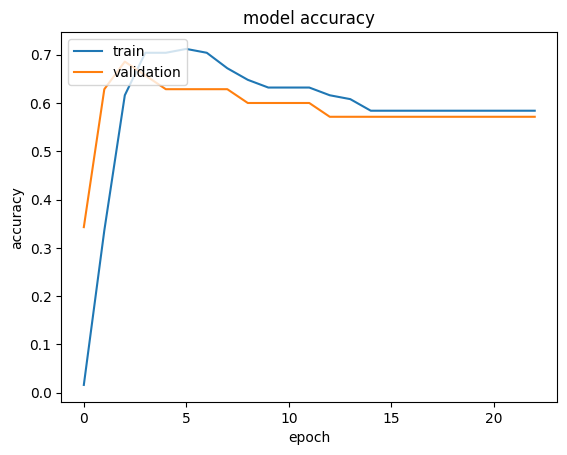

In [212]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

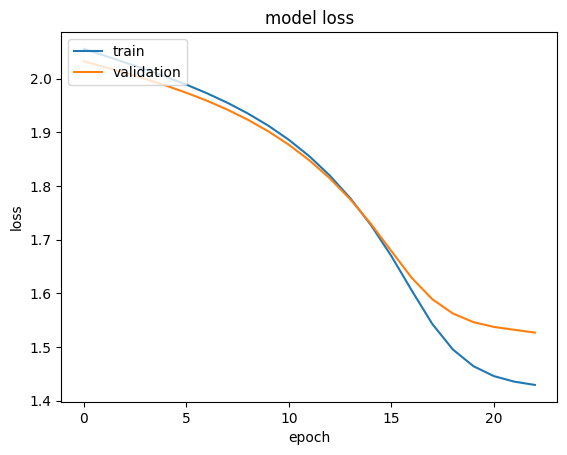

In [213]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Inference

In [214]:
model = load_model('model.keras')

In [215]:
val_encoder_input_data = np.zeros((len(val_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
val_decoder_input_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')
val_decoder_target_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [216]:
for i, (input_text, target_text) in enumerate(zip(val_hindi_text, val_english_text)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        val_decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            val_decoder_target_data[i, t - 1, target_char_index[char]] = 1

In [217]:
scores = model.evaluate([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5556 - loss: 2.1397
Val loss: 2.139711618423462
Val accuracy: 0.5555555820465088


In [218]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [219]:
reverse_input_char_index = dict((i, char) for char, i in input_char_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_char_index.items())

In [220]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_char_index['^']] = 1.0
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_chars[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '$' or len(decoded_sentence) > max_target_len):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

In [222]:
def predict_output(input_text):
    words = input_text.split(' ')
    transliterated_words = []
    for word in words:
        input_seq = np.zeros((1, max_input_len, num_encoder_tokens), dtype='float32')
        for t, char in enumerate(word):
            input_seq[0, t, input_char_index[char]] = 1
        decoded_word = decode_sequence(input_seq)
        transliterated_words.append(decoded_word.rstrip('$'))
    return ' '.join(transliterated_words)

In [223]:
text = 'शब्दावली'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: शब्दावली


KeyError: 'श'

In [224]:
text = 'क्या है'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))
#kya haai

Hindi text: क्या है


KeyError: '्'

In [225]:
text = 'रोशन'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: रोशन


KeyError: 'ो'

In [185]:
text = 'अनुवाद'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: अनुवाद
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Transliterated English text: anuwad


In [186]:
import os
print(os.getcwd())

/Users/mjere/Downloads/UROP


In [187]:
model.save('/Users/mjere/Downloads/UROP/model.keras')